In [1]:
# Initial setup of copula generative model based on parametric distributions for larger set of variables
# Extension to parametric design context - with predictive modeling
#
# Author: Alex Braafladt
#
# Version: v1 Initial creation 5/12/2022
#
# References:
#   -https://openturns.github.io/openturns/latest/theory/probabilistic_modeling/copulas.html#copula
#   -https://openturns.github.io/openturns/latest/auto_probabilistic_modeling/copulas/plot_composed_copula.html
#   -https://en.wikipedia.org/wiki/Copula_(probability_theory)

#### Interpolating models using kernel-based methods
The end goal is to develop a predictive model that can act as a surrogate for the simulation to provide the distributions of the selected output variables.

This notebook extends the previous ones by training a predictive model and testing the goodness-of-fit of the model using a basic cross validation strategy and then qualitatively showing the performance of the model across the input space.

##### External software required
Note that this notebook makes use of code developed in other work  ([paper 1](https://royalsocietypublishing.org/doi/abs/10.1098/rspa.2021.0495) and [paper 2](https://smartech.gatech.edu/bitstream/handle/1853/62941/Decker_Aviation2020_Final.pdf?sequence=1)) for the modeling specifics. This code has not yet been published, but contact this author or the authors of those papers for more information about obtaining it.

### Surrogate Modeling
Steps for building a predictive model as a surrogate of a simulation:
1. Sampling
2. Training
3. Validation
4. Prediction

In [15]:
# imports
# probabilistic and statistical modeling
import openturns as ot
import openturns.viewer as viewer
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats as st
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

# data and numerical functions
import numpy as np
import pandas as pd

# graphing and visualization functions
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText

# order reduction and data conditioners
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split

# design of experiments
from doepy import build

# os operations
import os as os
import sys
import datetime as dt
import pickle
from joblib import dump, load

# modeling code
from fit_pca import *
from sklearn.metrics import mean_squared_error, r2_score

# custom functions
import stats_functions as sf
import copula_gen_data as cpgen
from emulator_classes import Simulation, Data, Experiment, Analysis

#### Sampling

Using design of experiments (specifically latin hypercube sampling - using [doepy](https://doepy.readthedocs.io/en/latest/) here) to select points in the input space to evaluate the true simulation at.

#### Sampling - setting up cross validation
Following an approach to [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html), a training set and a test set where created based on sampling the input space. The simplified proof-of-concept here uses a basic separation into training and test only

In [3]:
# set up file I/O

# get current working directory
wrkdir = os.getcwd()
print('Current working directory: '+wrkdir)
# set up a data save directory for all future runs
newoutputdir = wrkdir+'\output'
if not os.path.exists(newoutputdir):
    os.makedirs(newoutputdir)
# set up a new directory to store files for the current run - updates at each new full run of notebook
curDatetime = dt.datetime.now()
datasavedir = newoutputdir + r'\\' + 'modelbuidling' + str(curDatetime.strftime('%Y%m%d%H%M%S'))
if not os.path.exists(datasavedir):
    os.makedirs(datasavedir)
print('Data save directory: '+datasavedir)

Current working directory: C:\Users\alexb\PycharmProjects\distribution-surrogates
Data save directory: C:\Users\alexb\PycharmProjects\distribution-surrogates\output\\modelbuidling20220516154654


In [8]:
%%time
# generate parametric data

# specify input space - these are the ranges of input parameters to interpolate between
input_ranges = np.array([[500.0, 55000.0], [100.0, 7000.0], [-5.0,3.0], [0.1, 0.9], [0.0, 0.5],
                         [40.0, 80.0], [0.5, 1.5], [1.0, 4.0], [0.5, 1.5], [2.0, 3.0],
                         [0.2, 0.8], [0.4, 0.8], [1., 15.], [7., 10.], [1., 10.]])

# flag which distributions are discrete for later use in analysis
discrete_flags = []
for i in range(25):
    discrete_flags.append(False)
for i in range(5):
    discrete_flags.append(True)

# generate the data based on doe sampling of the input space
# training simulation
training_exp = Experiment(input_ranges, num_cases=800, discrete_flags=discrete_flags)
training_exp.generate_data()

# test simulation
test_exp = Experiment(input_ranges, num_cases=200, discrete_flags=discrete_flags,
                      custom_scaler=training_exp.data.scaler)
test_exp.generate_data()

# statistical comparison simulation
comparison_exp_train = Experiment(input_ranges, num_cases=training_exp.doe_table.shape[0], discrete_flags=discrete_flags,
                                  custom_scaler=training_exp.data.scaler, custom_bins=training_exp.data.scaled_epdfs[0],
                                  custom_doe=training_exp.doe_table)
comparison_exp_train.generate_data()
comparison_exp_test = Experiment(input_ranges, num_cases=test_exp.doe_table.shape[0], discrete_flags=discrete_flags,
                                  custom_scaler=training_exp.data.scaler, custom_bins=test_exp.data.scaled_epdfs[0],
                                  custom_doe=test_exp.doe_table)
comparison_exp_test.generate_data()
# collect inputs from experiments
inputs_train = training_exp.doe_table
inputs_test = test_exp.doe_table

# collect data from experiments
data_train = training_exp.data
data_test = test_exp.data
data_comparison_train = comparison_exp_train.data
data_comparison_test = comparison_exp_test.data

# data processing from experimnets
data_scaler = training_exp.data.scaler

Using custom DOE table
Using custom DOE table
CPU times: total: 5min 41s
Wall time: 1min 8s


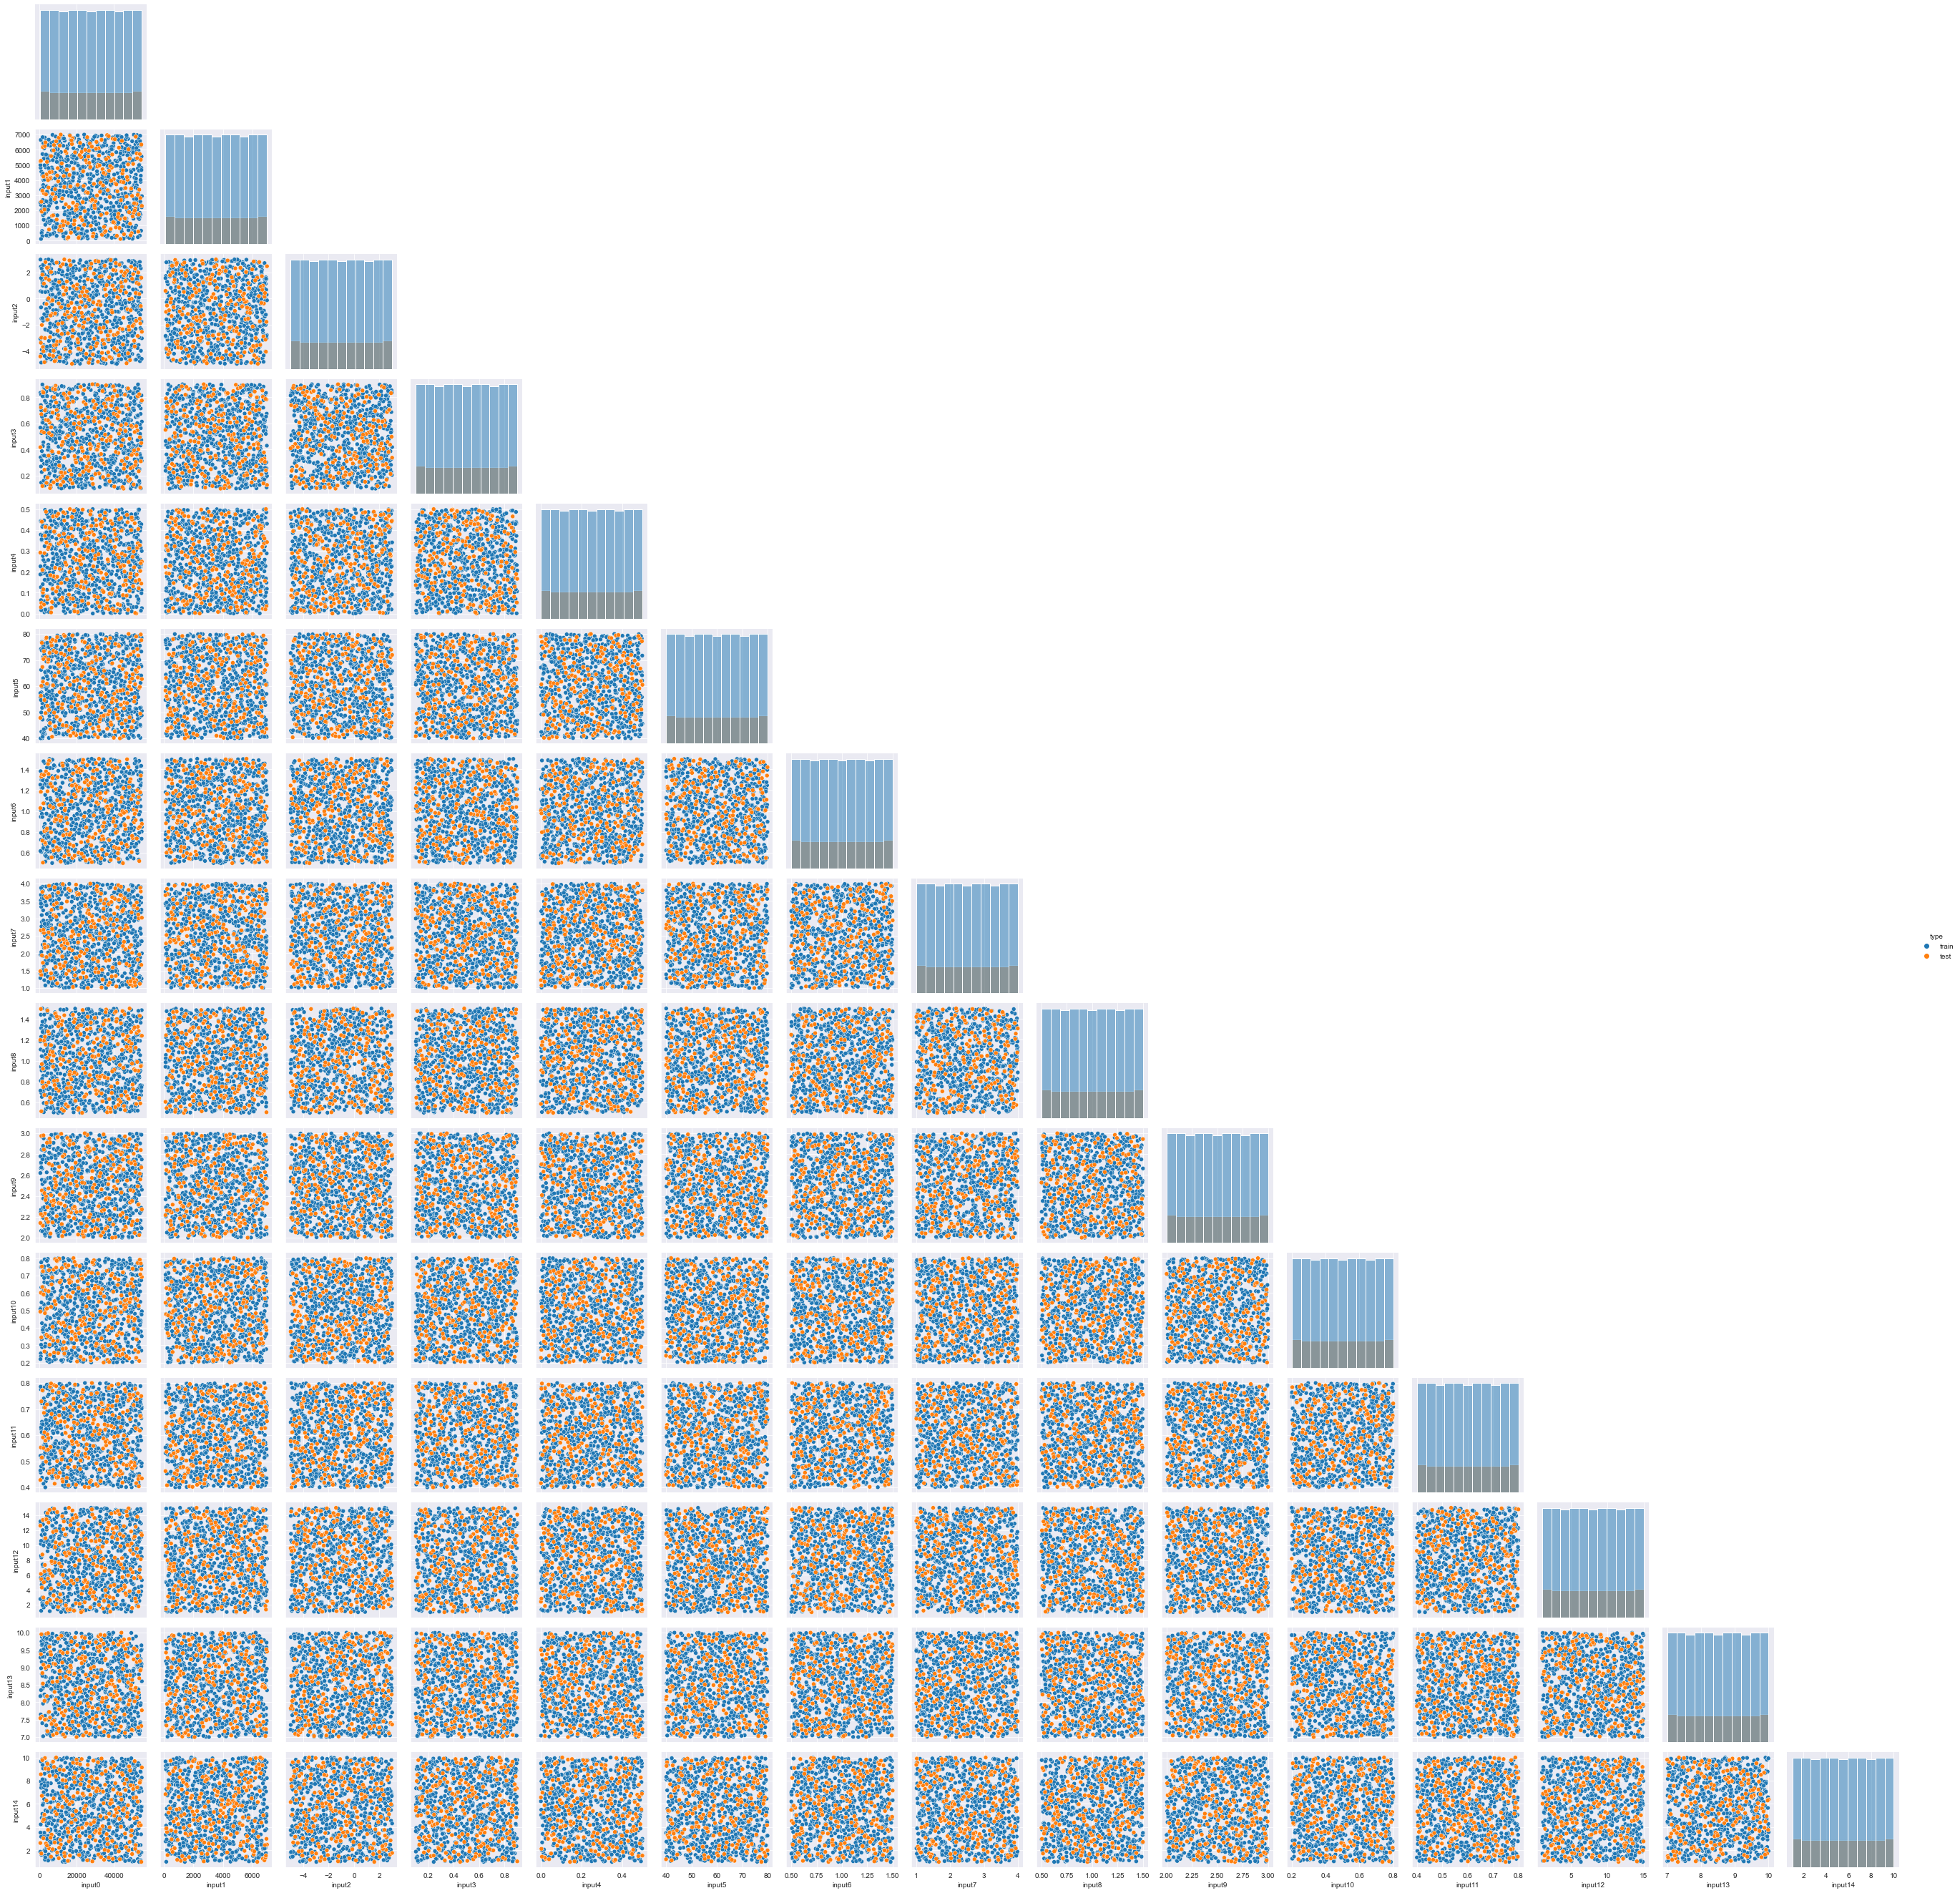

In [9]:
# plot the input space with samples from lhc doe

plot_df_train = inputs_train.copy(deep=True)
plot_df_train['type'] = 'train'
plot_df_test = inputs_test.copy(deep=True)
plot_df_test['type'] = 'test'
plot_inputs_df = pd.concat([plot_df_train, plot_df_test], axis=0, ignore_index=True)

g = sns.PairGrid(plot_inputs_df, hue='type', corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

#### Data sanity check
To check that the data seems reasonable, a basic check of the training and test data with their comparison data

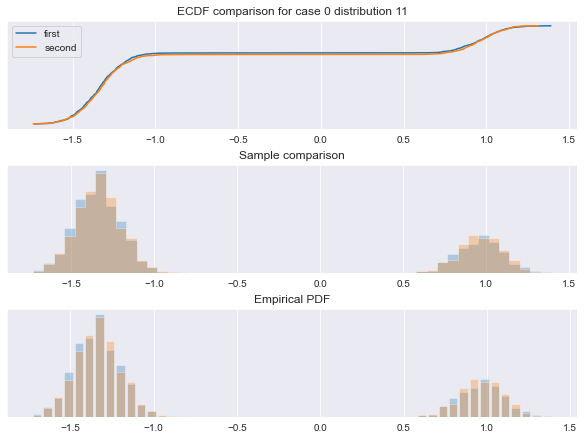

In [13]:
# plotting function ---------------------------
def plot_selected_distribution(first_data, second_data, case_num=0, dist_num=0):
    """Function to plot selected distribution representations"""
    # select set of data to be on plot
    # ecdf
    selected_first_ecdfx = first_data.scaled_ecdfs[1][case_num, :, dist_num]
    selected_second_ecdfx = second_data.scaled_ecdfs[1][case_num, :, dist_num]
    ecdfy = first_data.scaled_ecdfs[0]
    # epdf
    selected_first_epdfp = first_data.scaled_epdfs[1][case_num, :, dist_num]
    selected_second_epdfp = second_data.scaled_epdfs[1][case_num, :, dist_num]
    selected_epdfbins = first_data.scaled_epdfs[0][case_num, :, dist_num]
    # samples
    selected_first_samples = first_data.scaled_samples[case_num, :, dist_num]
    selected_second_samples = second_data.scaled_samples[case_num, :, dist_num]
    # plot
    fig3, ax3 = plt.subplots(3, 1, figsize=(8, 6), constrained_layout=True)
    ax = ax3.ravel()
    # ecdf
    ax[0].plot(selected_first_ecdfx, ecdfy, label='first')
    ax[0].plot(selected_second_ecdfx, ecdfy, label='second')
    ax[0].set_title("ECDF comparison for case " + str(case_num) + " distribution " + str(dist_num))
    ax[0].legend()
    ax[0].set_yticks(())
    # histogram
    ax[1].hist(selected_first_samples, bins=selected_epdfbins, alpha=0.3, histtype='stepfilled', label='first')
    ax[1].hist(selected_second_samples, bins=selected_epdfbins, alpha=0.3, histtype='stepfilled', label='second')
    ax[1].set_yticks(())
    ax[1].set_title('Sample comparison')
    # epdf
    center = (selected_epdfbins[:-1] + selected_epdfbins[1:]) / 2.
    width = (selected_epdfbins[1] - selected_epdfbins[0]) * 0.8
    ax[2].bar(center, selected_first_epdfp, width=width, alpha=0.3)
    ax[2].bar(center, selected_second_epdfp, width=width, alpha=0.3)
    ax[2].set_yticks(())
    ax[2].set_title('Empirical PDF')

plot_selected_distribution(data_test, data_comparison_test, 0, 11)

#### Set up data for model training
The interpolating model options considered here are radial basis functions and gaussian processes. The inputs correspond directly to the selected parametric variables from the distribution simulation setup, with ranges specified.

The outputs are the set of distributions generated by the simulation (30 distributions in this case). To fit a model the training data is organized into snapshot vectors - the distributions from each case are stacked together to form a single vector output from the simulation.

In [14]:
# format data for training model
# train
x_train = inputs_train.to_numpy()
y_train_snapshots = cpgen.pca_stack(data_train.scaled_ecdfs[1]).T
# test
x_test = inputs_test.to_numpy()
y_test_snapshots = cpgen.pca_stack(data_test.scaled_ecdfs[1]).T
# input ranges
x_ranges = tuple(map(tuple, input_ranges))

print('Shape of training ecdfx dataset inputs for snapshots: ', x_train.shape, ' outputs: ', y_train_snapshots.shape)
print('Shape of test ecdfx dataset inputs for snapshots: ', x_test.shape, ' outputs: ', y_test_snapshots.shape)

Shape of training ecdfx dataset inputs for snapshots:  (800, 15)  outputs:  (800, 30000)
Shape of test ecdfx dataset inputs for snapshots:  (200, 15)  outputs:  (200, 30000)


#### Train the model
This section uses additional code not yet added to the repository while waiting for the authors of that code to release it fully.

In [16]:
%%time
# interpolation model alternative 2: Gaussian Process with PCA RIC=1.0
# GP-PCA setup
gp_settings = {    # See doc strings in fit_pca.py for details
    'RIC': 1,
    'interp_method': 'gauss-t',
    'interp_kernel': 'matern32',
    'interp_parameter': None,
    'timing': True,
    'random_state': 1,
    'scale_inputs': False,
    'scale_outputs': False,
    'scale_embedding': False,
}
# Fit ROM
gpROM = FitPCA(**gp_settings)
gpROM.read_training_params(x_train, param_ranges=x_ranges)
gpROM.read_training_snapshots(y_train_snapshots)
gpROM.execute()
y_train_gp_predict = gpROM.predict(x_train)
y_test_gp_predict = gpROM.predict(x_test)
latent_gp = gpROM._interp_function(x_test)

POD Model fit time = 940.819157 s
CPU times: total: 35min 49s
Wall time: 23min 10s


In [ ]:
# set up class for Model
class Model:
    """
    Model object collecting ROM model, goodness-of-fit metrics, and also
    include a function to generate data to drive an interactive dash plot

    Attributes
    ----------

    Methods
    -------

    """
    def __init__(self, true_data=None, comparison_data=None, model_data=None, cross_val_type=None):
        self.true_data = true_data
        self.comparison_data = comparison_data
        self.model_data = model_data